In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
import warnings

pd.options.display.max_columns=999
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
seed = 101 # Lucky seed

Load and inspect House Sales in King County, USA dataset.

In [2]:
df = pd.read_csv('./data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Select features of interest and split into train/test sets.

In [3]:
X = df[['bedrooms', 'bathrooms', 'sqft_living',
        'sqft_lot', 'floors', 'waterfront',
        'view', 'condition', 'grade',
        'sqft_above', 'sqft_basement', 'lat', 'long']].values
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

Define target function and instantiate Bayesion Optimization object.

In [4]:
def target(**params):
    alpha = params['alpha']
    model = Ridge(alpha=alpha, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    return scores.mean()

In [5]:
params = {'alpha':(1e-6,100)}
bo = BayesianOptimization(target, params, random_state=seed)
bo.maximize(init_points=5, n_iter=10, acq='ucb')

Initialization
-----------------------------------------
 Step |   Time |      Value |     alpha | 
    1 | 00m00s |    0.66238 |   51.6399 | 
    2 | 00m00s |    0.66169 |   57.0668 | 
    3 | 00m00s |    0.66678 |    2.8474 | 
    4 | 00m00s |    0.66612 |   17.1522 | 
    5 | 00m00s |    0.66020 |   68.5277 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |     alpha | 
    6 | 00m01s |    0.66678 |    0.0002 | 
    7 | 00m01s |    0.66677 |    3.7857 | 
    8 | 00m02s |    0.66679 |    2.6818 | 
    9 | 00m02s |    0.66678 |    0.7413 | 
   10 | 00m02s |    0.66675 |    5.2371 | 
   11 | 00m01s |    0.66678 |    0.0184 | 
   12 | 00m02s |    0.66664 |    8.6207 | 
   13 | 00m02s |    0.66667 |    7.8276 | 
   14 | 00m02s |    0.66679 |    2.3881 | 
   15 | 00m02s |    0.66624 |   15.5796 | 


In [6]:
bo.res['max']

{'max_params': {'alpha': 2.3881495270650488}, 'max_val': 0.66678732654894857}

Generate predictions and evaluate performance on test set.

In [7]:
model = Ridge(**bo.res['max']['max_params']).fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_score(y_test, y_pred)

0.68306188561136549

Inspect hyperparameter space.

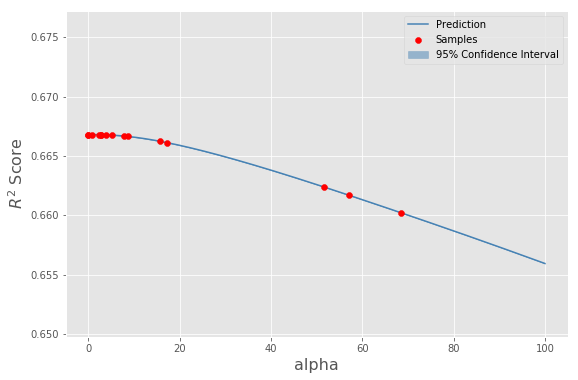

In [8]:
X_all = np.linspace(0, 100, 1000)
mu, std = bo.gp.predict(X_all.reshape(-1,1), return_std=True)

plt.figure(figsize=(9,6))
plt.scatter(bo.X.ravel(), bo.Y.ravel(), color='red', label='Samples', zorder=20)
plt.plot(X_all, mu, color='steelblue', label='Prediction')
plt.fill_between(X_all, mu-1.96*std, mu+1.96*std, color='steelblue', alpha=0.5, label='95% Confidence Interval')
plt.legend(loc='best')
plt.xlabel('alpha', fontsize=16)
plt.ylabel('$R^2$ Score', fontsize=16)
plt.show()

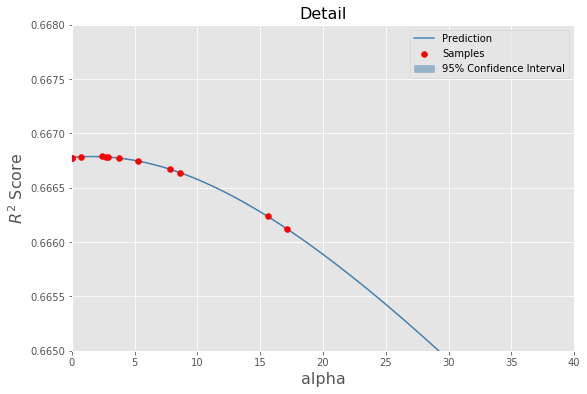

In [9]:
plt.figure(figsize=(9,6))
plt.scatter(bo.X.ravel(), bo.Y.ravel(), color='red', label='Samples', zorder=20)
plt.plot(X_all, mu, color='steelblue', label='Prediction')
plt.fill_between(X_all, mu-1.96*std, mu+1.96*std, color='steelblue', alpha=0.5, label='95% Confidence Interval')
plt.legend(loc='best')
plt.xlabel('alpha', fontsize=16)
plt.ylabel('$R^2$ Score', fontsize=16)
plt.axis(xmin=0, xmax=40, ymin=0.665, ymax=0.668)
plt.title('Detail', fontsize=16)
plt.show()